# Deep learning modeling

Deep learning models can be a good alternative to traditional machine learning models in this problem because some architectures like LSTM have been built to take into account the time dependance of data and they can do features selection automatically.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 SUPER'

We will try to reproduce this arquitecture:

<img src="figures/CNN-LSTM.png" alt="deep learning architecture" width="600"/>

*Hybrid CNN-LSTM architecture (Source: [Prediction of the remaining useful life of cutting tool using the Hurst exponent and CNN-LSTM.  Xiaoyang Zhang & Xin Lu1 & Weidong Li, & Sheng Wang](https://ieeexplore.ieee.org/document/4053566))*

The first step is to construct a 1D convolutional neural network (CNN) sub-model which will do feature extraction from each signal 

In [4]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, input_channels, cnn_filters) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(input_channels, cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(cnn_filters, cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(cnn_filters, out_channels=cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.4),
            nn.Conv1d(64, 1, kernel_size=3),
            nn.AdaptiveAvgPool1d(1),
        )
    def forward(self,x):
        return self.features(x)

Next the hybrid model which includes one of these feature extraction CNN sub-models per type of signal plus the LSTM model which will handle the prediction.

In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_filters=64, lstm_hidden_size=128, num_lstm_layers=2, num_classes=3, dropout_prob=0.3):
        super().__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers

        
        self.cnn_force = CNNFeatureExtractor(input_channels=3, cnn_filters=cnn_filters)
        self.cnn_vibration = CNNFeatureExtractor(input_channels=3, cnn_filters=cnn_filters)
        self.cnn_ae = CNNFeatureExtractor(input_channels=1, cnn_filters=cnn_filters)

        self.lstm = nn.LSTM(input_size=3, hidden_size=lstm_hidden_size, num_layers=num_lstm_layers, batch_first=True)

        self.dropout = nn.Dropout(p=dropout_prob)
        
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, forces, vibrations, ae, hidden = None):
        
        force_features = self.cnn_force(forces)
        vibration_features = self.cnn_vibration(vibrations)
        ae_features = self.cnn_ae(ae)

        # prepare features for LSTM
        combined_features = torch.cat((force_features, vibration_features, ae_features), dim=1)
        combined_features = combined_features.permute(0, 2, 1)

        if hidden is None:
            hidden = self.get_hidden(combined_features)

        lstm_out, hidden = self.lstm(combined_features, hidden)
        lstm_out = self.dropout(lstm_out)

        out = self.fc(lstm_out)

        out = out.squeeze(1)
        return out, hidden
    
    def get_hidden(self, x):
        # note the second axis is batch size, which is `x.shape[0]` for `batch_first=True`
        hidden = (
                torch.zeros(self.num_lstm_layers, x.shape[0], self.lstm_hidden_size, device=x.device),
                torch.zeros(self.num_lstm_layers, x.shape[0], self.lstm_hidden_size, device=x.device),
                )
        return hidden

Next steps:
* Create Data-loader
* Initialize model
* Define Optimizer and Loss
* 

In [6]:
# Dataset class for loading the signals and wear data
class CNCDataset(Dataset):
    def __init__(self, data_dir, wear_file, scaler=None):
        """
        Args:
            data_dir (string): Directory with all the signal csv files.
            wear_file (string): Path to the wear csv file.
            scaler (optional): Scaler for normalizing the data.
        """
        self.data_dir = data_dir
        self.scaler = scaler

        self.wear_data = pd.read_csv(wear_file).drop('cut', axis=1).values

        self.signal_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.csv')])

    def __len__(self):
        return len(self.signal_files)

    def __getitem__(self, idx):
        signal_file = os.path.join(self.data_dir, self.signal_files[idx])
        signal_df = pd.read_csv(signal_file)

        # Convert DataFrame to numpy and scale it
        signals = signal_df.values

        if self.scaler:
            signals = self.scaler.transform(signals)

        # Convert to Tensor and permute to [channels, time]
        signals_tensor = torch.tensor(signals, dtype=torch.float32).permute(1, 0)

        forces = signals_tensor[:3, :] 
        vibrations = signals_tensor[3:6, :]
        ae = signals_tensor[6:, :] 

        wear_target = torch.tensor(self.wear_data[idx], dtype=torch.float32).squeeze() # squeeze is necessary to match the output of the LSTM

        return {'forces': forces, 'vibrations': vibrations, 'ae': ae, 'wear_target': wear_target}

In [7]:
# Using c1 as the training set and c4 as the validation set
train_data_dir = '../data/raw/c1/c1'
train_wear_file = '../data/raw/c1/c1_wear.csv'

valid_data_dir = '../data/raw/c4/c4'
valid_wear_file = '../data/raw/c4/c4_wear.csv'

# Fit the scaler with all signals
all_signals = []
for file in os.listdir(train_data_dir):
    if file.endswith('.csv'):
        signal_data = pd.read_csv(os.path.join(train_data_dir, file)).values
        all_signals.append(signal_data)

all_signals = np.vstack(all_signals)
scaler = MinMaxScaler(feature_range=(0, 1))  # might try other scalers
scaler.fit(all_signals)

# Initialize datasets and dataloaders
train_dataset = CNCDataset(data_dir=train_data_dir, wear_file=train_wear_file, scaler=scaler)
valid_dataset = CNCDataset(data_dir=valid_data_dir, wear_file=valid_wear_file, scaler=scaler)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [8]:
train_dataset.__getitem__(5)

{'forces': tensor([[0.3052, 0.3053, 0.3055,  ..., 0.3048, 0.3046, 0.3044],
         [0.5064, 0.5059, 0.5055,  ..., 0.5036, 0.5033, 0.5029],
         [0.3666, 0.3672, 0.3677,  ..., 0.3614, 0.3608, 0.3600]]),
 'vibrations': tensor([[0.4459, 0.5253, 0.5201,  ..., 0.4924, 0.4843, 0.4869],
         [0.4844, 0.5887, 0.5835,  ..., 0.5618, 0.5491, 0.5519],
         [0.5077, 0.5843, 0.5768,  ..., 0.5614, 0.5515, 0.5525]]),
 'ae': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0021, 0.0021, 0.0021]]),
 'wear_target': tensor([56.2828, 52.7721, 38.6176])}

In [9]:
len(train_loader)

315

In [10]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    hidden  = None
    for batch in data_loader:
        # Moving data to the GPU
        forces = batch['forces'].to(device)
        vibrations = batch['vibrations'].to(device)
        ae = batch['ae'].to(device)
        wear_target = batch['wear_target'].to(device)

        # print("Forces: ", forces)
        # print("Wears: ", wear_target)

        optimizer.zero_grad()

        # Detach the hidden state from the previous batch to avoid backprop errors
        if hidden is not None:
            hidden = tuple([h.detach() for h in hidden])

        # Forward pass
        output, hidden = model(forces, vibrations, ae, hidden)
        # print("Predictions: ", output)

        assert output.shape == wear_target.shape, f"Output shape {output.shape} doesn't match target shape {wear_target.shape}"

        loss = criterion(output, wear_target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(data_loader)  # Average loss per batch

In [11]:
# Function to validate the model for one epoch
def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    hidden  = None
    with torch.no_grad():
        for batch in data_loader:
            # Extract forces, vibrations, ae, and targets from the batch
            forces = batch['forces'].to(device)
            vibrations = batch['vibrations'].to(device)
            ae = batch['ae'].to(device)
            wear_target = batch['wear_target'].to(device)

            # Forward pass
            output, hidden = model(forces, vibrations, ae, hidden)

            assert output.shape == wear_target.shape, f"Output shape {output.shape} doesn't match target shape {wear_target.shape}"

            # Compute loss
            loss = criterion(output, wear_target)
            running_loss += loss.item()

    return running_loss / len(data_loader)  # Average loss per batch

In [ ]:
import time

# Step 4: Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Step 5: Train and validate the model
num_epochs = 500
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss = validate_one_epoch(model, valid_loader, criterion, device)

    epoch_duration = time.time() - start_time
    minutes, seconds = divmod(epoch_duration, 60)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Time: {int(minutes)} min {int(seconds)} sec')

Epoch 1/500, Train Loss: 599.2340, Validation Loss: 3721.9613, Time: 1 min 7 sec
Epoch 2/500, Train Loss: 604.5262, Validation Loss: 14696.3486, Time: 1 min 7 sec
Epoch 3/500, Train Loss: 613.3764, Validation Loss: 1351.4807, Time: 1 min 7 sec
Epoch 4/500, Train Loss: 362.7719, Validation Loss: 2467.3217, Time: 1 min 7 sec
Epoch 5/500, Train Loss: 475.8795, Validation Loss: 1629.5588, Time: 1 min 6 sec
Epoch 6/500, Train Loss: 815.8164, Validation Loss: 1431.5284, Time: 1 min 5 sec
Epoch 7/500, Train Loss: 745.4865, Validation Loss: 2307.7345, Time: 1 min 5 sec
Epoch 8/500, Train Loss: 1168.8068, Validation Loss: 1800.1082, Time: 1 min 5 sec
Epoch 9/500, Train Loss: 983.1993, Validation Loss: 2771.4904, Time: 1 min 5 sec
Epoch 10/500, Train Loss: 1168.4891, Validation Loss: 1555.5561, Time: 1 min 5 sec
Epoch 11/500, Train Loss: 991.2616, Validation Loss: 1394.7399, Time: 1 min 5 sec
Epoch 12/500, Train Loss: 919.5869, Validation Loss: 1706.0371, Time: 1 min 5 sec
Epoch 13/500, Train Lo

In [13]:
def run_inference(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    hidden = None
    
    with torch.no_grad():  # No need to compute gradients during inference
        for batch in data_loader:
            forces = batch['forces'].to(device)
            vibrations = batch['vibrations'].to(device)
            ae = batch['ae'].to(device)

            # Forward pass
            output, hidden = model(forces, vibrations, ae, hidden) 
            
            # Collect predictions out of the gpu
            predictions.append(output.cpu().numpy())

    predictions = np.vstack(predictions)
    
    return predictions

In [14]:
test_data_dir = '../data/raw/c4/c4'  # Directory with test signals
test_wear_file = '../data/raw/c4/c4_wear.csv'  # Wear data file (if you have true labels for testing)

test_dataset = CNCDataset(data_dir=test_data_dir, wear_file=test_wear_file, scaler=scaler)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
predictions = run_inference(model, test_loader, device)

In [16]:
predictions

array([[ 41.86656 ,  49.533226,  43.391495],
       [ 54.585045,  62.421947,  51.324398],
       [ 61.192036,  64.459145,  57.101273],
       [ 70.91339 ,  72.372604,  67.113556],
       [ 85.63789 ,  85.0845  ,  83.60482 ],
       [108.88217 , 106.45018 , 106.49657 ],
       [112.81577 , 110.06216 , 110.35493 ],
       [113.24802 , 110.464745, 110.77962 ],
       [113.34042 , 110.55116 , 110.8707  ],
       [113.38608 , 110.59381 , 110.91582 ],
       [113.42212 , 110.627464, 110.95151 ],
       [113.4557  , 110.6588  , 110.98476 ],
       [113.488434, 110.68935 , 111.01718 ],
       [113.52075 , 110.71951 , 111.049194],
       [113.552795, 110.749405, 111.08093 ],
       [113.58458 , 110.77907 , 111.11242 ],
       [113.61615 , 110.80853 , 111.143684],
       [113.64749 , 110.83778 , 111.17473 ],
       [113.67861 , 110.86682 , 111.20556 ],
       [113.70952 , 110.89566 , 111.236176],
       [113.740204, 110.9243  , 111.26658 ],
       [113.77069 , 110.95276 , 111.29677 ],
       [11

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_true_vs_pred(true_vals, pred_vals):
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    
    plt.figure(figsize=(10, 6))
    
    for i in range(true_vals.shape[1]):  # Assuming 3 wear targets (one per flute)
        plt.plot(true_vals[:, i], label=f'True Flute {i+1}', linestyle='-', marker='o')
        plt.plot(pred_vals[:, i], label=f'Predicted Flute {i+1}', linestyle='--', marker='x')
    
    plt.title("True vs Predicted Wear Values for Each Flute")
    plt.xlabel("Sample Index")
    plt.ylabel("Wear Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
real_wear_data = pd.read_csv(test_wear_file).drop('cut', axis=1).values

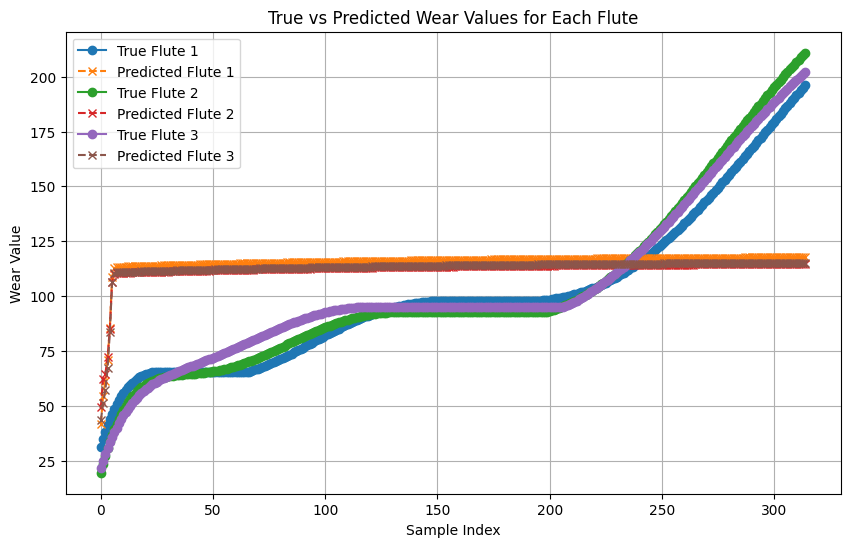

In [19]:
plot_true_vs_pred(real_wear_data, predictions)